[Sumber](https://folk.uio.no/tiago/teaching/ast2210/sunpy_aia.ipynb)

# Sunpy and AIA data

[Sunpy](https://www.sunpy.org) is an open source Python package for solar physics. It allows you to interact, visualise and analyse different types of solar data. Here we will use it to work with AIA data.

## Initialisation

Before we start, it is a good practice to place all your package imports and any special commands in the first code cell of your jupyter notebook. Here we will use the following:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 9]  # make plots larger

import sunpy.map
from sunpy.instr.aia import aiaprep
from sunpy.net import Fido, attrs as a

from astropy.coordinates import SkyCoord
from astropy import units as u

import warnings
warnings.filterwarnings("ignore")

## Searching and downloading data

Now the next step is to actually get some data! We are going to use Sunpy to download some AIA data. There are several ways of acquiring data with Sunpy, and here we will use [Fido](http://docs.sunpy.org/en/stable/guide/acquiring_data/fido.html) to query the [Virtual Solar Observatory](https://sdac.virtualsolar.org/cgi/search) (VSO). 

First we do a search to find out what AIA data are available on a time range, and the 171 channel:

In [2]:
result = Fido.search(a.Time('2014-09-19T05:59:00', '2014-09-19T06:01:00'), 
                     a.Instrument("aia"), a.Wavelength(171*u.angstrom), 
                     a.vso.Sample(12*u.second))
result

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2014-09-19 06:00:35,2014-09-19 06:00:36,SDO,AIA,FULLDISK,171.0 .. 171.0
2014-09-19 05:59:59,2014-09-19 06:00:00,SDO,AIA,FULLDISK,171.0 .. 171.0
2014-09-19 05:59:35,2014-09-19 05:59:36,SDO,AIA,FULLDISK,171.0 .. 171.0
2014-09-19 06:00:11,2014-09-19 06:00:12,SDO,AIA,FULLDISK,171.0 .. 171.0
2014-09-19 06:00:47,2014-09-19 06:00:48,SDO,AIA,FULLDISK,171.0 .. 171.0
2014-09-19 05:59:11,2014-09-19 05:59:12,SDO,AIA,FULLDISK,171.0 .. 171.0
2014-09-19 06:00:59,2014-09-19 06:01:00,SDO,AIA,FULLDISK,171.0 .. 171.0
2014-09-19 05:59:23,2014-09-19 05:59:24,SDO,AIA,FULLDISK,171.0 .. 171.0


In the above we used `a.vso.Sample(12*u.second)`, to make sure that the search looks for all images with a 12 second cadence (maximum for AIA). In this two minute interval, we see several observations but the cadence is not 12 seconds but around 36 seconds. This is because not all channels are exposed simultaneously (there are 10 channels and only 4 telescopes, so AIA cycles through the channels). 

So far have only queried the database. Now, let us download the file closest to 06:00 (4th in sequence):

In [3]:
file_download = Fido.fetch(result[0, 3], site='ROB',path = '../DATA')

Files Downloaded: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/file]


Even though we requested only one file, the above may take a while to download. We used `ROB` for site, which is the Royal Observatorium of Belgium. If you have problems, you can also use `MPS` or `KIS` for `site`. Fido downloads the file(s) to a directory in your hard drive, typically in `~/sunpy/data`. The locations of the file(s) are saved on the list `file_download`. In this case, it is:

In [4]:
file_download

['..\\DATA\\aia_20140919_060011_0171_image_lev1.fits']

Now let us load this file using `Sunpy.map` and check its metadata:

In [5]:
aia1 = sunpy.map.Map(file_download[0])
aia1

SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 171.0 Angstrom
Wavelength:		 171.0 Angstrom
Observation Date:	 2014-09-19 06:00:11
Exposure Time:		 2.000196 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.59948897 0.59948897] arcsec / pix
Reference Pixel:	 [2053.     2049.1001] pix
Reference Coord:	 [0. 0.] arcsec
array([[ 0,  0,  0, ...,  0, -1, -2],
       [ 2,  1, -1, ..., -1,  0, -1],
       [-1, -2,  1, ...,  0,  1,  1],
       ...,
       [-1,  0, -2, ..., -1,  1, -1],
       [ 0,  0, -2, ...,  2,  0, -2],
       [ 0,  0, -2, ..., -1,  3,  2]], dtype=int16)

!!! info "Data levels"
    Data from space missions is classified according to different levels of calibration. From the time it is downloaded from the satellite to when you use it for scientific analysis, it undergoes many transformations. It is first saved as raw data, then placed into a FITS file with basic metadata, and later corrected for different effects such as flat fields, darks, geometry, reorganised into different files, etc. Some of these operations can be destructive (i.e. you can no longer go back to the raw data from the calibrated data), and that is why data are usually distributed in different levels. For science you want the highest possible level, but having a lower level can be useful in case the calibration procedure has improved. Different space missions have different data level numbers. For example, an AIA level 1 file is **not the same** as an IRIS level 1 file.


Before proceeding with any scientific analysis, we need to perform some basic calibration on these data. Distributed AIA files are in the so-called "level 1" format, which has been flat-fielded, dark subtracted, de-spiked and corrected for bad pixels. However, additional calibration is necessary to correct for geometric effects, align the image axes with solar north, and place all channels in a common plate scale (spatial pixel size). This correction is called "level 1.5", and you should perform it for all files used in scientific work.

To correct AIA to level 1.5 data, we use the `aiaprep` function that we previously imported:

In [6]:
aia = aiaprep(aia1)

In [7]:
aia

SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 171.0 Angstrom
Wavelength:		 171.0 Angstrom
Observation Date:	 2014-09-19 06:00:11
Exposure Time:		 2.000196 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.6 0.6] arcsec / pix
Reference Pixel:	 [2048.5 2048.5] pix
Reference Coord:	 [0. 0.] arcsec
array([[-4, -3, -5, ..., -7, -7, -7],
       [ 0,  1,  1, ..., -7, -7, -7],
       [ 0,  0,  0, ..., -7, -7, -7],
       ...,
       [-7, -7, -7, ..., -7, -7, -7],
       [-7, -7, -7, ..., -7, -7, -7],
       [-7, -7, -7, ..., -7, -7, -7]], dtype=int16)

## Working with Map objects

We can now have a look at the data with the `.plot()` method:

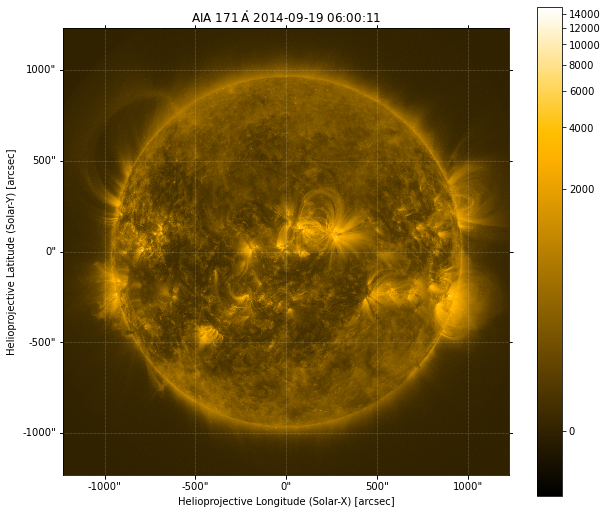

In [8]:
aia.plot()
plt.colorbar()
plt.show()

We can now see the whole Sun at 17.1 nm on the chosen date. The `.plot()` method does several things in the background. It not only plots the image data, but also sets the image scale to be solar (x, y) coordinates, and automatically scales the image in a log scale (see color bar on left). 

??? question "Can you find two sunspots in the image?"
    At this time there were two sunspots visible in the Sun. But you will hardly find them in the 171 image. This is because these images sample the Corona at almost 1 million K. This is well above the visible surface, which is where sunspots are better seen. More on this later.

Alternatively, we can also plot the image manually using matplotlib's `imshow()`:

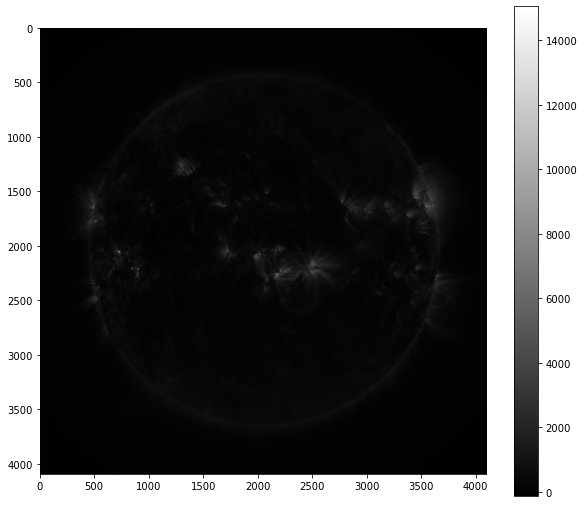

In [9]:
fig, ax = plt.subplots()
plt.imshow(aia.data, cmap='gist_gray')
plt.colorbar()

This basic plot lacks many of the useful features of Sunpy. We have the axes in pixels and not coordinates, linear scale, and a black and white colormap. 

You can read more about how to use `Sunpy.map` and plotting in the [Guide to Sunpy](http://docs.sunpy.org/en/stable/guide/data_types/maps.html).



## Working with coordinates

Different coordinate systems exist for celestial bodies. On Earth, we are used to a [Geographic coordinate system](https://en.wikipedia.org/wiki/Geographic_coordinate_system) where a fixed location can always be located by longitude and latitude (e.g. Oslo is always at 59°55′0″N 10°44′0″E). The Sun is also approximately spherical, so we could similarly use *Heliographic* coordinates. However, these have several issues that make their general use difficult:

*  As seen in the 171 image, many solar features such as jets and loops extend beyond the surface, so besides latitude and longitude we also need radius to describe a point, leading to projection effects
* Unlike Earth, the Sun does not rotate as a solid body, it has *differential rotation*, meaning the equator rotates faster than the poles.  Therefore, points are not really fixed at different latitudes.

The most used solar coordinates are instead *Helioprojective* cartesian, or solar XY coordinates. In these coordinates, the Sun is projected into an (x, y) plane as seen from Earth. The origin of this system is the solar disk centre, and they are typically in units of arcsecond (″). With the solar radius being 959″.63, the range of solar XY coordinates is typically from -1000″ to 1000″. You can read more about [solar coordinate systems](https://www.aanda.org/articles/aa/pdf/2006/14/aa4262-05.pdf).

In astronomy, coordinate systems are described by the [World Coordinate System](https://fits.gsfc.nasa.gov/fits_wcs.html) (WCS), and in Python this is handled by astropy's [WCS module](http://docs.astropy.org/en/stable/wcs/). The FITS files from AIA and IRIS have the coordinate information written as WCS metadata, which are then read by Sunpy to plot the correct coordinate axes in `.plot()`. Any transformation to the data is then aware of the coordinates. For example, we can rotate our Sunpy map by 45° and see what happens with the output:

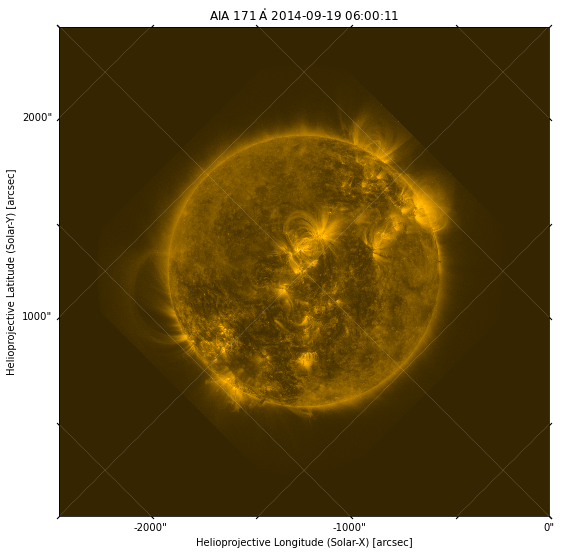

In [10]:
aia_rot = aia.rotate(45 * u.deg)
aia_rot.plot()

Now the image has rotated, but so have the coordinates. This takes a while because the original image is huge (4096x4096), and the output is even larger. In fact, these AIA images are so large that when looking at the full disk we don't see the many small details. Sunpy allows us to create a submap, a subregion of a map. We can select this solar coordinates, and need to define the bottom left and top right corner coordinates of the region we want to select:

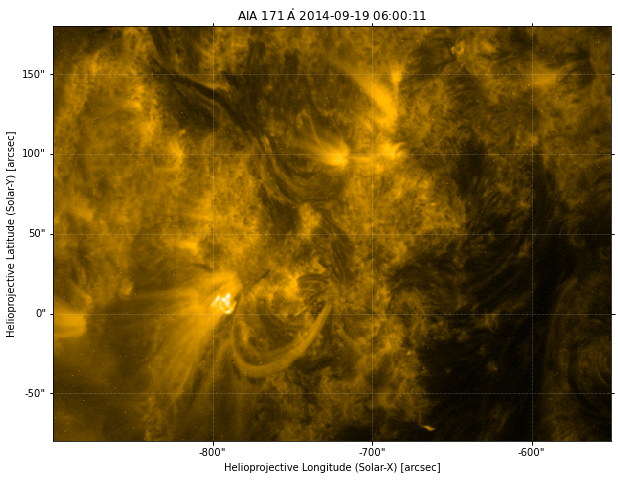

In [11]:
top_right = SkyCoord(-550*u.arcsec, 180*u.arcsec, frame=aia.coordinate_frame)
bottom_left = SkyCoord(-900 * u.arcsec, -80. * u.arcsec, frame=aia.coordinate_frame)
aia_sub = aia.submap(top_right, bottom_left)
aia_sub.plot()

This `aia_sub` image is much smaller than the original.

## Using multiple channels

Now let us use the power of AIA and look at the same solar region, but closer to the photosphere. Let's search for and download the 1700 channel at about the same time:

Files Downloaded: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.08s/file]


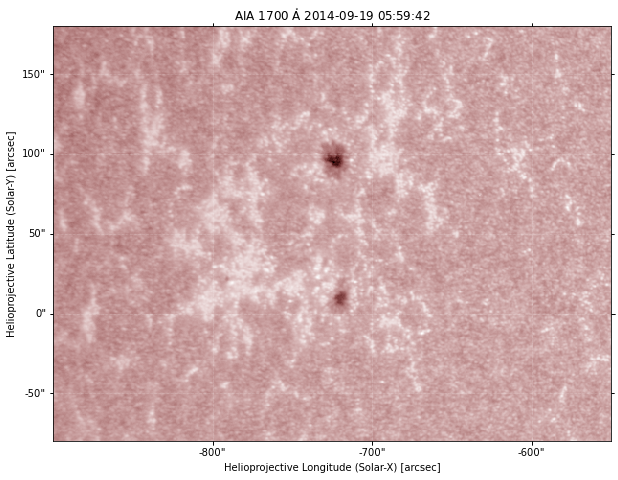

In [12]:
result = Fido.search(a.Time('2014-09-19T05:59:00', '2014-09-19T06:01:00'), 
                     a.Instrument("aia"), a.Wavelength(1700 * u.angstrom), 
                     a.vso.Sample(12 * u.second))
# result closest in time to the 171 image:
file_download = Fido.fetch(result[0, 2], site='ROB',path='../DATA')
aia1 = sunpy.map.Map(file_download[0])
aia1700 = aiaprep(aia1)
aia1700_sub = aia1700.submap(top_right, bottom_left)
aia1700_sub.plot()

Now you can see the sunspots! This 1700 image is a lot closer to the visible surface. It shows sunspots and also bright regions, which are caused by large magnetic fields. The 171 and 1700 images are so far apart that it is difficult to find common parts. We can use matplotlib to animate in between the two images:

In [13]:
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots()
im1 = aia1700_sub.plot()
im2 = aia_sub.plot()

# add last image twice to avoid quick looping
# anim = animation.ArtistAnimation(fig, [[im1], [im2], [im1]], 
#                                  interval=1000, blit=True)
plt.close(fig)
# HTML(anim.to_html5_video())

## Time evolution

In the last exercise in this series we will look at a time series of AIA data. We want to see how these two sunspots came about, and how they evolve. Making use of Fido, we will download a series of AIA images and make a movie. In this example we will use 1700 images, but your are free to choose another channel if you want.

!!! danger
    We are now entering into dangerous territory. You will write some code to download a series of images. If this is done incorrectly, you will end up downloading a HUGE volume of data. In the best case scenario you will have to wait for a long time for the code to finish. In the worst case scenario your IP may be blocked by the VSO for exceeding reasonable download limits, your hard drive will be 100% full and your computer will slow down to a halt. Before you run `Fido.fetch()`, double check how many files you are attempting to download (each file is ~10 MB), and use common sense when trying to download multiple files.
    
??? question "What happens if you run `Fido.fetch()` twice?"
    It will download the file(s) again. But it will not overwrite existing files, it will create a new version with a number at the end. E.g.:
    
    * First run: `aia_20140919_060030_1700_image_lev1.fits`
    * Second run: `aia_20140919_060030_1700_image_lev1.0.fits`
    * Third run: `aia_20140919_060030_1700_image_lev1.1.fits`
    * And so on...
    
    So use `Fido.fetch()` with care.
    
    
Now we will download a sequence of 1700 images before and after the one above, for a interval of about 4 days and a cadence of 6 hours. Feel free to change the AIA channel and if you want, the cadence. The code below will download about 15 images, totalling about **180 MB**. If you use a higher cadence, this might increase substantially, or alternatively you can choose a lower cadence to reduce the download size.

In [14]:
result = Fido.search(a.Time('2014-09-16T18:00:00', '2014-09-20T07:00:00'), 
                     a.Instrument("aia"), a.Wavelength(1700*u.angstrom), 
                     a.vso.Sample(6*u.hour))
result

Start Time,End Time,Source,Instrument,Type
float64,float64,float64,float64,float64


In [ ]:
# Download ALL results (use with care!)
file_download = Fido.fetch(result, site='ROB',path='../DATA')
# sort by date
file_download = sorted(file_download)
# Load all files into a Map sequence
tmp = sunpy.map.Map(file_download)

In [ ]:
# In this case, we do not run aiaprep because we're only using one channel
aia_seq = []
for img in tmp:
    top_right = SkyCoord(-550*u.arcsec, 180*u.arcsec, frame=img.coordinate_frame)
    bottom_left = SkyCoord(-900 * u.arcsec, -80. * u.arcsec, frame=img.coordinate_frame)
    aia_seq.append(img.submap(top_right, bottom_left))

To save time not having to do this all the time, we are going to save the submaps into FITS files using the `.save()` method of the SunPy Map. First we create new filenames based on the downloaded files.

In [ ]:
new_files = [a.split('lev1')[0] + 'lev1_sub.fits' for a in file_download]
for img, file_name in zip(aia_seq, new_files):
    img.save(file_name)

And now we animate the sequence of all the images, loading from the submap files:

In [ ]:
aia = sunpy.map.Map(new_files)

fig, ax = plt.subplots()
# image half down sequence to get better scaling
plot_obj = aia[len(aia) // 2].plot()

def animate(i):
    ax.set_title("AIA %s %s" % (aia[i].meta['wave_str'],
                                aia[i].meta['t_obs'][:-8]))
    plot_obj.set_data(aia[i].data)
    return (plot_obj,)

# anim = animation.FuncAnimation(fig, animate, init_func=None,
#                                frames=len(aia), interval=500, blit=True)
plt.close(fig)
# HTML(anim.to_html5_video())

You should see above an animation of the sunspots evolving as the Sun rotates.